## 概览

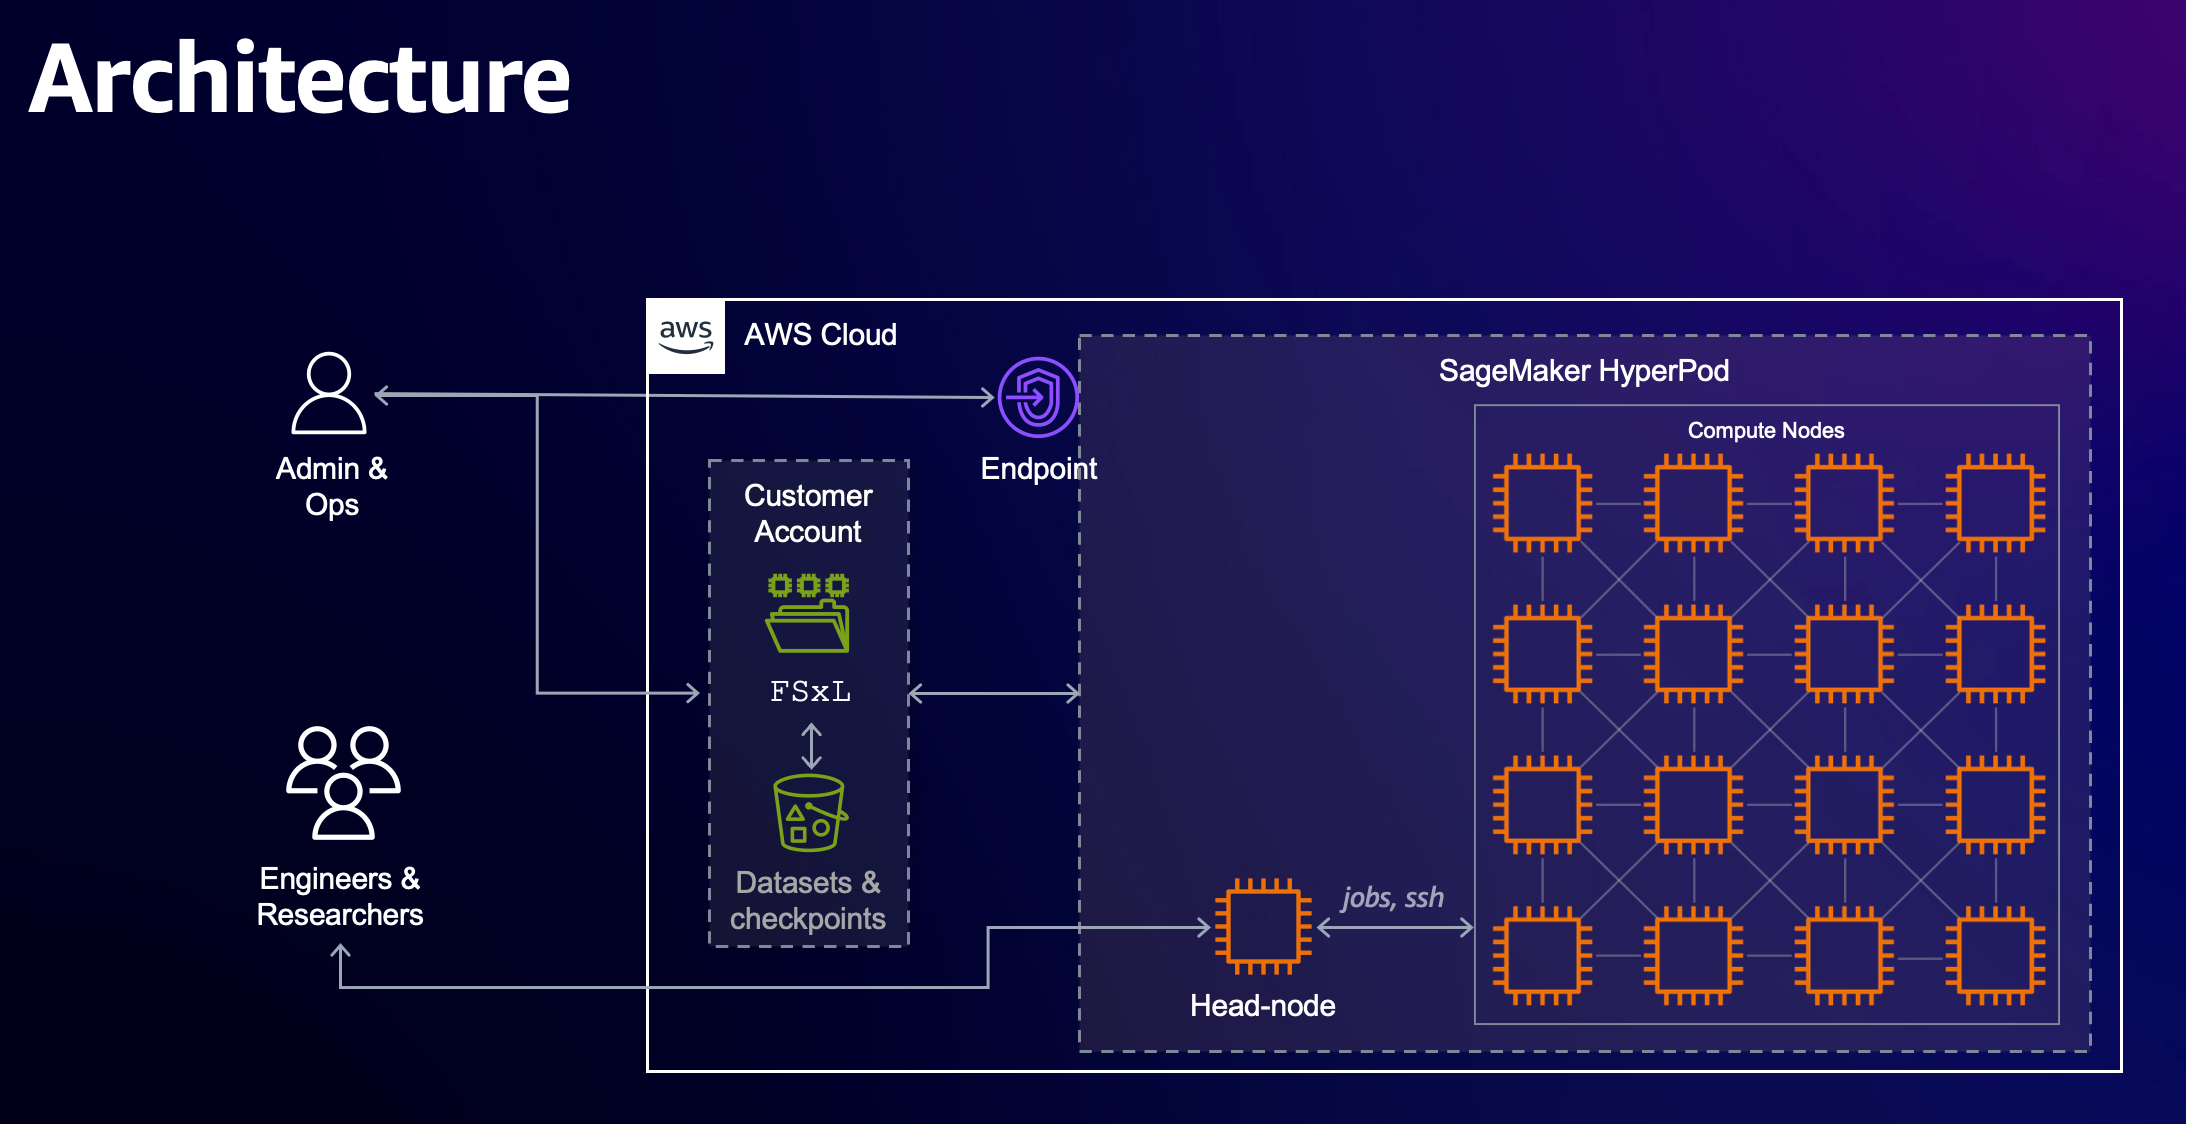

## 前置准备


### IAM

配置IAM权限
  * 创建集群的账户角色(e.g: sagemaker executor role)加hyperpod cluster的policy
  * hyperpod相关权限参见hyperpod_iam_policy.json


### 命令行工具

```shell
# Copy 到命令行执行
source ~/.bashrc

echo "==============================================="
echo "  Install jq, envsubst (from GNU gettext utilities) and bash-completion ......"
echo "==============================================="
sudo yum -y install jq bash-completion tree amazon-efs-utils


echo "==============================================="
echo "  Upgrade awscli to v2 ......"
echo "==============================================="
sudo rm -fr /tmp/aws
sudo mv /bin/aws /bin/aws1
sudo mv ~/anaconda3/bin/aws ~/anaconda3/bin/aws1
# ls -l /usr/local/bin/aws
# rm -fr awscliv2.zip aws
rm -rf /usr/local/bin/aws 2> /dev/null
rm -rf /usr/local/aws-cli 2> /dev/null
rm -rf aws awscliv2.zip 2> /dev/null
curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "/tmp/awscliv2.zip"
unzip /tmp/awscliv2.zip -d /tmp
sudo /tmp/aws/install
# sudo ./aws/install --update
which aws_completer
echo $SHELL
cat >> ~/.bashrc <<EOF
complete -C '/usr/local/bin/aws_completer' aws
EOF
source ~/.bashrc
aws --version


echo "==============================================="
echo "  Install session-manager ......"
echo "==============================================="
curl "https://s3.amazonaws.com/session-manager-downloads/plugin/latest/linux_64bit/session-manager-plugin.rpm" -o "/tmp/session-manager-plugin.rpm"
sudo yum install -y /tmp/session-manager-plugin.rpm
session-manager-plugin

```

### 环境变量

In [ ]:
%%bash

mkdir -p ~/SageMaker/custom

#  Load custom bashrc
cat >> ~/.bashrc <<EOF
bashrc_files=(bashrc)
path="/home/ec2-user/SageMaker/custom/"
for file in \${bashrc_files[@]}
do 
    file_to_load=\$path\$file
    if [ -f "\$file_to_load" ];
    then
        . \$file_to_load
        echo "loaded \$file_to_load"
    fi
done
EOF

In [ ]:
%%bash

source ~/.bashrc

mkdir -p /home/ec2-user/SageMaker/custom/

wget https://raw.githubusercontent.com/TipTopBin/awesome-sagemaker/main/infra/env.sh -O /home/ec2-user/SageMaker/custom/env.sh
chmod +x /home/ec2-user/SageMaker/custom/env.sh
/home/ec2-user/SageMaker/custom/env.sh /home/ec2-user/SageMaker/custom/bashrc

In [ ]:
%%bash

source ~/.bashrc

HP_S3_BUCKET="ia-$ACCOUNT_ID-us-west-2" # 按需调整 S3 桶名
echo "export HP_S3_BUCKET=${HP_S3_BUCKET}" | tee -a ~/SageMaker/custom/bashrc


SAGE_ROLE_ARN="arn:aws:iam::${ACCOUNT_ID}:role/sage-admin"
echo "export SAGE_ROLE_ARN=${SAGE_ROLE_ARN}" | tee -a ~/SageMaker/custom/bashrc

### 网络

检查VPC
  * 可以使用已有的VPC，但需要该VPC带私有子网+公有子网，且私有子网通过nat走公有子网igw能访问外网
  * 已有的VPC需要创建S3和DynamoDB的的终端节点
  * 如果新建VPC，可以使用cloudformation一键创建
    * 参考模版：https://github.com/TipTopBin/awesome-sagemaker/blob/main/infra/vpc.yaml 

如果 DynamoDB 端点没有创建，请放开以下的注释，并执行单元格。或者在 VPC 控制台创建端点。

In [ ]:
# # Find the RouteTable ID and VPC ID associated with our SageMaker instance so that we can create an S3 Gateway endpoint

# import boto3, os, ipaddress

# ec2_client = boto3.client('ec2')

# # Using the IP of this notebook instance, retrieve associated Subnet/AZ/VPC details
# sagemaker_vpc_ip = os.popen('ip addr show eth2').read().split("inet ")[1].split("/")[0]
# subnet_all = ec2_client.describe_subnets()
# for subnet in subnet_all['Subnets']:
#     if ipaddress.ip_address(sagemaker_vpc_ip) in ipaddress.ip_network(subnet['CidrBlock']):
#         sagemaker_subnet_id = subnet['SubnetId']
#         sagemaker_vpc_id = subnet['VpcId']
#         sagemaker_az_id = subnet['AvailabilityZoneId']
#         sagemaker_cidr = subnet['CidrBlock']
#         print('Characteristics of this SageMaker notebook instance:')
#         print(f'          IP: {sagemaker_vpc_ip}')
#         print(f'    SubnetID: {sagemaker_subnet_id}')
#         print(f'        CIDR: {sagemaker_cidr}')
#         print(f'        AzID: {sagemaker_az_id}')
#         print(f'         VPC: {sagemaker_vpc_id}')


# route_tables = ec2_client.describe_route_tables(
#         Filters=[
#         {
#             'Name': 'vpc-id',
#             'Values': [sagemaker_vpc_id]
#         },
#         {
#             'Name': 'tag:Name',
#             'Values': ['*Public*', '*Private*']
#         }            
        
#     ]
# )
# # Get the route table ID associated with the subnet ID
# # for route_table in route_tables['RouteTables']:
# #     for association in route_table['Associations']:
# #         if 'SubnetId' in association:
# #             if association['SubnetId'] == sagemaker_subnet_id:
# #                 sagemaker_route_table_id = association['RouteTableId']
# #                 print(f'RouteTableID: {sagemaker_route_table_id}')

# # get all route table id in a specified vpc 
# route_table_ids = []
# for route_table in route_tables['RouteTables']:
#     route_table_ids.append(route_table['RouteTableId'])

# print(route_table_ids)

In [ ]:
# # Create a gateway endpoint for use with the DynamoDB
# import boto3, os, json, ipaddress

# dynamodb_gw_endpoint_name = 'dynamodb-gw-vpce'

# # Get the region and define the service string that will be needed to define the gateway endpoint
# region = boto3.Session().region_name
# service = "com.amazonaws.{}.dynamodb".format(region)
# print(f'Region: {region}')
# print(f'Endpoint Service type: {service}\n')

# # Create the Gateway Endpoint which will automatically update the specified route table
# response = ec2_client.create_vpc_endpoint(
#     DryRun=False,
#     VpcEndpointType='Gateway',
#     VpcId=sagemaker_vpc_id,
#     ServiceName=service,
#     RouteTableIds=route_table_ids,
#     TagSpecifications=[
#         {
#             'ResourceType': 'vpc-endpoint',
#             'Tags': [
#                 { 'Key': 'Name', 'Value': f'{dynamodb_gw_endpoint_name}' },
#             ],
#         },
#     ],
# )
# response_code = response['ResponseMetadata']['HTTPStatusCode']
# if response_code == 200:  # <-- response code of 200 indicates success
#     dynamodb_vpc_endpoint_id = response['VpcEndpoint']['VpcEndpointId']
#     response_policy_json = json.loads(response['VpcEndpoint']['PolicyDocument'])
#     print(f'Created DynamoDB Gateway endpoint `{dynamodb_vpc_endpoint_id}` with policy as follows:\n')
#     print(json.dumps(response_policy_json, indent=4))

### EFS

生产环境的配置，建议放在共享存储
- 将 EFS 挂载到本地
- 一个 HyperPod 集群，对应一个目录

注意：
- EFS 只适合放配置文件，共享代码
- 不适合放大量训练数据

需要注意吞吐，这里有2种模式：
- 1. Elastic
  - 动态扩展     
- 2. Provisioned
  - 预置     


参考：
- https://docs.aws.amazon.com/efs/latest/ug/performance.html

|Storage and throughput configuration|   |Latency|   |Maximum IOPS|   |Maximum throughput|   |   |
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|**File system type**|**Throughput mode**|**Read operations**|**Write operations**|**Read operations**|**Write operations**|**Per-file-system read**1|**Per-file-system write**1|**Per-client read/write**|
|**Regional**|Elastic|As low as 250 µs|As low as 2.7 ms|90,000–250,0002|50,000|3–20 GiBps|1–5 GiBps|500 MiBps|
|**Regional**|Provisioned|As low as 250 µs|As low as 2.7 ms|55,000|25,000|3–10 GiBps|1–3.33 GiBps|500 MiBps|
|**Regional**|Bursting|As low as 250 µs|As low as 2.7 ms|35,000|7,000|3–5 GiBps|1–3 GiBps|500 MiBps|
|**One Zone**|Elastic, Provisioned, or Bursting|As low as 250 microseconds (µs)|As low as 1.6 milliseconds (ms)|35,000|7,000|3–5 gibibytes per second (GiBps)|1–3 GiBps|500 mebibytes per second (MiBps)|




可以通过控制台创建 EFS，注意选择多可用区。或者通过以下命令行快速构建。

In [ ]:
%%bash

# 创建 EFS 文件系统
source ~/.bashrc

export HP_EFS_FS_NAME="hp-efs" # 用于自动集成，共享配置等
export HP_EFS_FS_ID=$(aws efs create-file-system --encrypt --performance-mode generalPurpose --throughput-mode elastic --tags Key=Name,Value=${HP_EFS_FS_NAME} --query 'FileSystemId' --output text)

echo "export HP_EFS_FS_NAME=${HP_EFS_FS_NAME}" >> ~/SageMaker/custom/bashrc
echo "export HP_EFS_FS_ID=${HP_EFS_FS_ID}" | tee -a ~/SageMaker/custom/bashrc

sleep 30

In [ ]:
%%bash

# 创建挂载点
source ~/.bashrc

# private 子网
EKS_PRI_SUBNET_LIST=$(aws ec2 describe-subnets --filters "Name=vpc-id,Values=${EKS_VPC_ID}"  "Name=tag:Name,Values=*Private*" "Name=cidr-block,Values=*$(echo $EKS_VPC_CIDR | cut -d . -f 1).$(echo $EKS_VPC_CIDR | cut -d . -f 2).*" | jq '.Subnets | sort_by(.AvailabilityZone)' | jq '.[] .SubnetId')
SUB_IDX=1
for subnet in $EKS_PRI_SUBNET_LIST
do
    subnet_id=$(echo $subnet | tr -d '"')
    aws efs create-mount-target --file-system-id ${HP_EFS_FS_ID} --subnet-id ${subnet_id} --security-group ${EKS_SHAREDNODE_SG}
done

In [ ]:
%%bash

# 挂载到本地
source ~/.bashrc

mkdir -p /home/ec2-user/SageMaker/efs/${HP_EFS_FS_NAME}
# sudo mount -t efs -o tls ${EFS_FS_ID}:/ /efs # Using the EFS mount helper
echo "${HP_EFS_FS_ID}.efs.${AWS_REGION}.amazonaws.com:/ /home/ec2-user/SageMaker/efs/${HP_EFS_FS_NAME} efs _netdev,tls 0 0" | sudo tee -a /etc/fstab
sudo mount -a
sudo chown -hR +1000:+1000 /home/ec2-user/SageMaker/efs*
#sudo chmod 777 /home/ec2-user/SageMaker/efs*

## 搭建集群


In [ ]:
%%bash

source ~/.bashrc

# 注意不要重复执行
# 准备集群名字等环境变量
export HP_CLUSTER_NAME=hp-cluster-2

mkdir -p /home/ec2-user/SageMaker/efs/${HP_EFS_FS_NAME}/${HP_CLUSTER_NAME}

echo "export HP_CLUSTER_NAME=\"$HP_CLUSTER_NAME\"" >> ~/SageMaker/custom/bashrc

### 启动脚本


In [ ]:
%%bash

source ~/.bashrc

cd /home/ec2-user/SageMaker/efs/${HP_EFS_FS_NAME}/${HP_CLUSTER_NAME}

if [ -e "./awesome-distributed-training" ]; then
  echo "Repo exists, pull"
  cd awesome-distributed-training
  git pull
  cd ..
else
  echo "Repo does not exist, clone"
  git clone https://github.com/TipTopBin/awesome-distributed-training.git
fi

In [ ]:
%%bash

# Sync scripts to S3
source ~/.bashrc

cd /home/ec2-user/SageMaker/efs/${HP_EFS_FS_NAME}/${HP_CLUSTER_NAME}

# # 替换环境变量 
# 自动挂载才需要
# source ~/.bashrc && cd /home/ec2-user/SageMaker/efs/${EFS_FS_NAME}/${HP_CLUSTER_NAME}
# export EFS_MOUNT_POINT="\/efs\/${EFS_FS_NAME}"
# export S3_MOUNT_POINT="\/s3\/${IA_S3_BUCKET}"
# sed "s/\${AWS_REGION}/$AWS_REGION/g; s/\${HP_EFS_ID}/$HP_EFS_FS_ID/g; s/\${HP_S3_BUCKET}/$IA_S3_BUCKET/g; s/\${HP_EFS_MP}/$EFS_MOUNT_POINT/g; s/\${HP_S3_MP}/$S3_MOUNT_POINT/g" ./awesome-distributed-training/5.easy_hyperpod/setup_storage_sample.sh > ./awesome-distributed-training/5.easy_hyperpod/setup_storage.sh

# 同步到 S3
# aws s3 cp --recursive ./ s3://${BUCKET}/LifeCycleScripts/base-config
aws s3 sync ./awesome-distributed-training/5.easy_hyperpod/ s3://$HP_S3_BUCKET/sagemaker/${HP_CLUSTER_NAME}/LifeCycleScripts/base-config

### SSH

In [ ]:
%%bash

# 第一次
source ~/.bashrc && cd /home/ec2-user/SageMaker/efs/${HP_EFS_FS_NAME}/${HP_CLUSTER_NAME}

# Create SSH Key 
aws ec2 create-key-pair --key-name ${HP_CLUSTER_NAME} --query 'KeyMaterial' --output text > ./${HP_CLUSTER_NAME}_private_key.pem
chmod 400 ./${HP_CLUSTER_NAME}_private_key.pem

ssh-keygen -f ./${HP_CLUSTER_NAME}_private_key.pem -y > ./${HP_CLUSTER_NAME}_public_key.pem

# cp to s3
aws s3 cp ./${HP_CLUSTER_NAME}_private_key.pem s3://$HP_S3_BUCKET/sagemaker/${HP_CLUSTER_NAME}/LifeCycleScripts/base-config/priv.pem
aws s3 cp ./${HP_CLUSTER_NAME}_public_key.pem s3://$HP_S3_BUCKET/sagemaker/${HP_CLUSTER_NAME}/LifeCycleScripts/base-config/pub.pem

# 本地免密
sudo cp ./${HP_CLUSTER_NAME}_private_key.pem ~/.ssh/id_rsa
sudo cp ./${HP_CLUSTER_NAME}_public_key.pem ~/.ssh/id_rsa.pub
sudo chown -R ec2-user:ec2-user ~/.ssh/

In [ ]:
%%bash

# 第二次 （创建额外集群时）

source ~/.bashrc && cd /home/ec2-user/SageMaker/efs/${HP_EFS_FS_NAME}/${HP_CLUSTER_NAME}

# cp local to s3
aws s3 cp ~/.ssh/id_rsa s3://$HP_S3_BUCKET/sagemaker/${HP_CLUSTER_NAME}/LifeCycleScripts/base-config/priv.pem
aws s3 cp ~/.ssh/id_rsa.pub s3://$HP_S3_BUCKET/sagemaker/${HP_CLUSTER_NAME}/LifeCycleScripts/base-config/pub.pem

### 配置文件

In [ ]:
%%bash

source ~/.bashrc && cd /home/ec2-user/SageMaker/efs/${HP_EFS_FS_NAME}/${HP_CLUSTER_NAME}

# 请注意调整 instance_group_name 以及机型配置，例如 ml.p4de.24xlarge
# 调整 "partition_name": "dev"
cat > ${HP_CLUSTER_NAME}.json << EOL
{
    "ClusterName": "${HP_CLUSTER_NAME}",
    "InstanceGroups": [
      {
        "InstanceGroupName": "controller-machine",
        "InstanceType": "ml.m5.xlarge",
        "InstanceCount": 1,
        "LifeCycleConfig": {
          "SourceS3Uri": "s3://$HP_S3_BUCKET/sagemaker/${HP_CLUSTER_NAME}/LifeCycleScripts/base-config/",
          "OnCreate": "on_create.sh"
        },
        "ExecutionRole": "${SAGE_ROLE_ARN}",
        "ThreadsPerCore": 1
      },
      {
        "InstanceGroupName": "trn1",
        "InstanceType": "ml.trn1.32xlarge",
        "InstanceCount": 1,
        "LifeCycleConfig": {
          "SourceS3Uri": "s3://$HP_S3_BUCKET/sagemaker/${HP_CLUSTER_NAME}/LifeCycleScripts/base-config/",
          "OnCreate": "on_create.sh"
        },
        "ExecutionRole": "${SAGE_ROLE_ARN}",
        "ThreadsPerCore": 1
      }
    ],
    "Tags": [ 
        { 
           "Key": "exp_test",
           "Value": "${HP_CLUSTER_NAME}"
        }
    ],
    "VpcConfig": {
      "SecurityGroupIds": ["$EKS_CUSTOMNETWORK_SG", "$EKS_ADDITIONAL_SG", "$EKS_SHAREDNODE_SG"],
      "Subnets":["$EKS_PRI_SUBNET_1"]
    }
}
EOL


instance_type=$(cat ${HP_CLUSTER_NAME}.json | jq '.InstanceGroups[1].InstanceType')
cat > provisioning_parameters.json << EOL
{
  "version": "1.0.0",
  "workload_manager": "slurm",
  "controller_group": "controller-machine",
  "worker_groups": [
    {
      "instance_group_name": "trn1",
      "partition_name": ${instance_type}
    }
  ]
}
EOL

# 一定别忘了同步 provisioning_parameters.json 到 S3
aws s3 cp provisioning_parameters.json s3://$HP_S3_BUCKET/sagemaker/${HP_CLUSTER_NAME}/LifeCycleScripts/base-config/

### 执行创建


In [ ]:
%%bash

source ~/.bashrc && cd /home/ec2-user/SageMaker/efs/${HP_EFS_FS_NAME}/${HP_CLUSTER_NAME}

aws sagemaker create-cluster \
  --cli-input-json file://${HP_CLUSTER_NAME}.json \
  --region $AWS_REGION

In [ ]:
%%bash

source ~/.bashrc

CLUSTER_STATUS=$(aws sagemaker describe-cluster --cluster-name ${HP_CLUSTER_NAME} --query ClusterStatus --output text)

# Target to InService

echo $(date -u) "Checking cluster status..."

while [ "$CLUSTER_STATUS" == "Creating" ]
do
  CLUSTER_STATUS=$(aws sagemaker describe-cluster --cluster-name ${HP_CLUSTER_NAME} --query ClusterStatus --output text)
  if [ "$CLUSTER_STATUS" == "Creating" ]
  then
    echo $(date -u) "Cluster under ${CLUSTER_STATUS}. Waiting for 10 seconds before checking again."
    sleep 10
  fi
done

echo $(date -u) "HyperPod cluster ${HP_CLUSTER_NAME} is ${CLUSTER_STATUS}."

### 检查集群

In [ ]:
%%bash

source ~/.bashrc

aws sagemaker describe-cluster --cluster-name ${HP_CLUSTER_NAME}

In [ ]:
%%bash

# 查看节点
source ~/.bashrc

aws sagemaker list-cluster-nodes --cluster-name ${HP_CLUSTER_NAME}

## 管理集群

* hyperpod cluster的服务器id命名规则为：sagemaker-cluster:${CLUSTER_ID}_${CONTROLLER_GROUP}-${INSTANCE_ID}
* 使用 ssm client 可以任意登陆集群任何一台服务器
* 登陆后为root账户，ubuntu操作系统，可以su - ubuntu账户

### Head 


SSH 免密登录
```shell
ssh ubuntu@ip-192-168-201-xx # 请替换 DNS
```

In [ ]:
%%bash

source ~/.bashrc && cd /home/ec2-user/SageMaker/efs/${HP_EFS_FS_NAME}/${HP_CLUSTER_NAME}

wget https://raw.githubusercontent.com/TipTopBin/awesome-distributed-training/main/1.architectures/5.sagemaker-hyperpod/easy-ssh.sh -O easy-ssh.sh
chmod +x easy-ssh.sh
# easy-ssh.sh -c controller-machine ${HP_CLUSTER_NAME} # 复制到独立的命令行执行
# sudo su - ubuntu
# sinfo
# squeue

### Worker


SSM 方式
```shell
# sagemaker-cluster:{CLUSTER_ID}_{CONTROLLER_GROUP}-${INSTANCE_ID}
TARGET_ID=sagemaker-cluster:xxx_worker-group-c5-2x-i-021090ac36dxxx
aws ssm start-session --target $TARGET_ID --region ${AWS_REGION}
```



### 挂载存储


```shell
srun -N 1 ./mount.sh # 在单个节点上运行 mount.sh 脚本

srun -N 
```

### 更新集群

注意：
- 如果启动脚本有更新，请先一定同步脚本文件到 S3

In [ ]:
%%bash

source ~/.bashrc && cd /home/ec2-user/SageMaker/efs/${HP_EFS_FS_NAME}/${HP_CLUSTER_NAME}

# https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-hyperpod-operate-cli-command.html#sagemaker-hyperpod-operate-cli-command-update-cluster
cat > ${HP_CLUSTER_NAME}-update-$(date '+%Y-%m-%d').json << EOF
{
    "ClusterName": "${HP_CLUSTER_NAME}",
    "InstanceGroups": [
          {
            "InstanceGroupName": "controller-machine",
            "InstanceType": "ml.m5.xlarge",
            "InstanceCount": 1,
            "LifeCycleConfig": {
              "SourceS3Uri": "s3://$HP_S3_BUCKET/sagemaker/${HP_CLUSTER_NAME}/LifeCycleScripts/base-config/",
              "OnCreate": "on_create.sh"
            },
            "ExecutionRole": "${SAGE_ROLE_ARN}",
            "ThreadsPerCore": 1
          },
          {
            "InstanceGroupName": "trn1",
            "InstanceType": "ml.trn1.32xlarge",
            "InstanceCount": 2,
            "LifeCycleConfig": {
              "SourceS3Uri": "s3://$HP_S3_BUCKET/sagemaker/${HP_CLUSTER_NAME}/LifeCycleScripts/base-config/",
              "OnCreate": "on_create.sh"
            },
            "ExecutionRole": "${SAGE_ROLE_ARN}",
            "ThreadsPerCore": 1
          }
    ]
}
EOF

# 必须同步更新 provisioning_parameters
# 必须同步更新 provisioning_parameters
# 必须同步更新 provisioning_parameters
cat > provisioning_parameters.json << EOL
{
  "version": "1.0.0",
  "workload_manager": "slurm",
  "controller_group": "controller-machine",
  "worker_groups": [
    {
      "instance_group_name": "trn1",
      "partition_name": "ml.trn1.32xlarge"
    }
  ]
}
EOL


aws s3 cp provisioning_parameters.json s3://$HP_S3_BUCKET/sagemaker/${HP_CLUSTER_NAME}/LifeCycleScripts/base-config/

In [ ]:
%%bash

source ~/.bashrc && cd /home/ec2-user/SageMaker/efs/${HP_EFS_FS_NAME}/${HP_CLUSTER_NAME}

update_cluster=${HP_CLUSTER_NAME}-update-$(date '+%Y-%m-%d').json

aws sagemaker update-cluster \
  --cli-input-json file://$update_cluster

### 删除集群

```
aws sagemaker delete-cluster --cluster-name hp-cluster-1 # 注意替换集群名
```